In [52]:
import pandas as pd
import torch
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole, MolToImage  # Enables RDKit’s IPython integration.
IPythonConsole.ipython_useSVG=True  # Use SVG for clearer images than default PNGs.
import os
import openbabel as ob
import json

In [53]:
def xyz_to_smiles(filepath):
    # Initialize Open Babel conversion object
    obConversion = ob.OBConversion()
    obConversion.SetInAndOutFormats("xyz", "smi")

    # Create a new molecule object
    mol = ob.OBMol()

    # Read the molecule from .xyz file
    if not obConversion.ReadFile(mol, filepath):
        raise FileNotFoundError(f"Could not read file: {filepath}")

    # Convert to SMILES
    smiles = obConversion.WriteString(mol).strip().split()[0]

    # Canonicalize SMILES
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return smiles
    else:
        canonical_smiles = Chem.MolToSmiles(mol)
        return canonical_smiles

In [54]:
timestamp = "05-09-2024_00-54-42"
disco_cycles = 13

In [55]:
output_dir = os.path.join("src/disco/disco_outputs", timestamp)

with open(os.path.join(output_dir, "disco_config.json"), "r") as f:
    disco_args = json.load(f)
    n_samples = disco_args['n_samples']
    objective = disco_args['objective']

In [56]:
df = pd.DataFrame()
for cycle in range(disco_cycles):
    cycle_dir = os.path.join(output_dir, f"cycle_{cycle+1}")
    scores = torch.load(os.path.join(cycle_dir, "scores.pt"))
    for sample in range(n_samples):
        filename = os.path.join(cycle_dir, f"molecule_{sample+1}.xyz")
        smiles = xyz_to_smiles(filename)
        score = scores[sample].item()

        row = pd.DataFrame({
            'smiles': [smiles],
            'score': [score]
        })
        df = pd.concat([df, row])
    
df = df.reset_index(drop=True)
df
        

/home/jose/DiSco/.venv/lib64/python3.11/site-packages/openbabel/__init__.py:26: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[12:25:57] Explicit valence for atom # 2 N, 4, is greater than permitted
[12:25:57] Explicit valence for atom # 1 C, 5, is greater than permitted
[12:25:57] Explicit valence for atom # 4 N, 4, is greater than permitted
[12:25:57] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:25:57] Explicit valence for atom # 1 N, 4, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is src/disco/disco_outputs/05-09-2024_00-54-42/cycle_2/molecule_94.xyz)



,smiles,score
0,O=Cn1cnoc1=O,-6.868923
1,C#Cc1nnoc1C#N,-7.613881
2,N#Cc1nc(C=O)no1,-8.979337
3,C#C[C@]1(C#N)CO1,-6.782963
4,O=C1[CH]N=C[N]N1,-9.211562
...,...,...
1295,O=C(F)C(F)(F)N(O)F,-2.944050
1296,O=COC(=O)C(F)(F)F,-2.992762
1297,O=C(O)[C@]1(F)OC1(F)F,-2.583628
1298,FC(F)N(F)C(F)F,-3.724452


In [57]:
df_sorted = df.sort_values(by='score', ascending=(True if objective=='minimize' else False))
df_sorted

,smiles,score
1212,O=C(O)OOC(F)(F)F,-1.529783
1119,O=CN(F)OOC(=O)F,-1.530581
1257,O=C(O)OOC(F)(F)F,-1.647794
1248,FC(F)(F)OOC(F)(F)F,-1.726398
1229,O=C(F)ON(F)C(F)(F)F,-1.758554
...,...,...
123,Oc1ncc[nH]1,-9.785640
34,[NH]C1=[N]=CN=NN1,-9.847891
60,[NH]C1=NN=C[N]N1,-9.954803
35,[NH]C1=NN=C[N]N1,-10.120045


In [58]:
df_unique = df_sorted.drop_duplicates(subset='smiles')
df_unique = df_unique.reset_index(drop=True)
df_unique

,smiles,score
0,O=C(O)OOC(F)(F)F,-1.529783
1,O=CN(F)OOC(=O)F,-1.530581
2,FC(F)(F)OOC(F)(F)F,-1.726398
3,O=C(F)ON(F)C(F)(F)F,-1.758554
4,O=C(O)OC(F)(F)OF,-1.888734
...,...,...
657,OCc1nnon1,-9.782187
658,Oc1ncc[nH]1,-9.785640
659,[NH]C1=[N]=CN=NN1,-9.847891
660,[NH]C1=NN=C[N]N1,-9.954803


O=C(O)OOCF


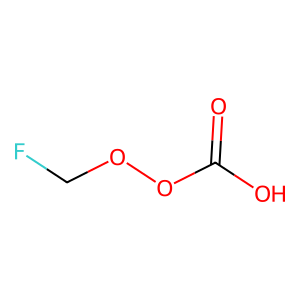

In [68]:
i = 8
smiles = df_unique['smiles'][i]
print(smiles)
mol = Chem.MolFromSmiles(smiles)
MolToImage(mol)